<center>

# **Project 1: Introduction to Deep Learning**

---

### Submitted by  
## **Humblot Arthur**
## **Anvarov Bekhzod**
## **El Belghiti Ghita**

### University  
## **Politechnico di Torino**

---

### Academic Year  
**2025 - 2026**

</center>


**###Task 1: Data Preprocessing**

The goal of this section is to make sure our set of data can be used efficiently by our FNN. First we will remove the Nan data and duplicate data.
We set a random seed than we delete the missing and duplicates values from our dataset in the same way of the document notebook 1-FFNN of the courses.

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

import time

In [2]:
# Set random seed for reproducibility
random_seed = 110
np.random.seed(random_seed)

Remove missing values (NaN) and duplicate entries.
Q:How many samples did you have before and after removing missing and duplicates entries?

In [3]:
# Set random seed for reproducibility
random_seed = 110
np.random.seed(random_seed)

# Open the dataset
data = pd.read_csv("dataset_lab_1.csv")
print("Number of rows in our dataset", data.size)

# Remove rows with missing values
data = data.replace([np.inf, -np.inf], np.nan) # whith the fit_transform python was complaigning about inf data so I add this line
data = data.dropna()
print("Number of rows after missing values", data.size)

# Remove duplicates
data = data.drop_duplicates()
print("Number of rows after duplicates", data.size)

# Encode labels
label_encoder = LabelEncoder()
data['Label'] = label_encoder.fit_transform(data['Label'])



Number of rows in our dataset 535619
Number of rows after missing values 535160
Number of rows after duplicates 499562


 Split the dataset to extract a training, validation and test sets (60%, 20%, 20%).
Remember to set the seeds if you want reproducibility.
 • Focus on the training and validation partitions. Check for the presence of outliers
 and decide on the correct normalization.– Q: How did you normalize the data? Why did you choose it?

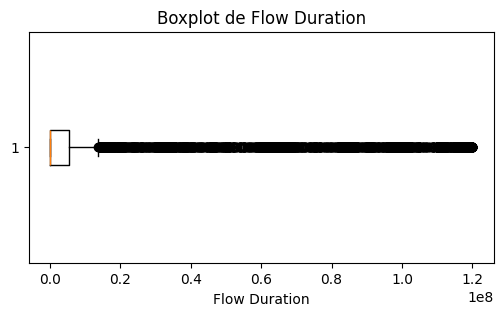

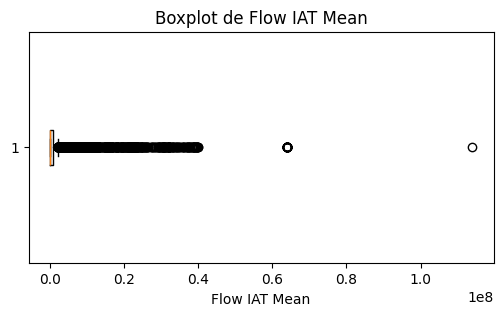

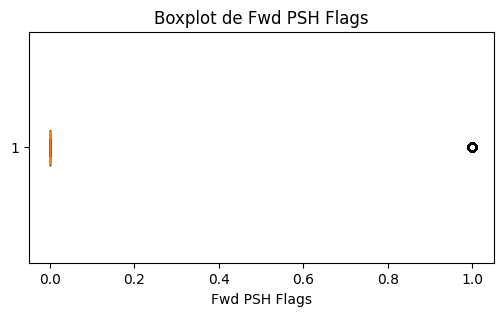

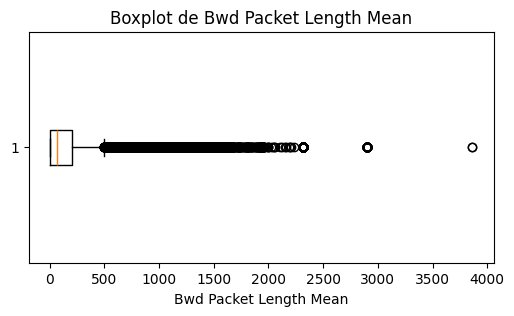

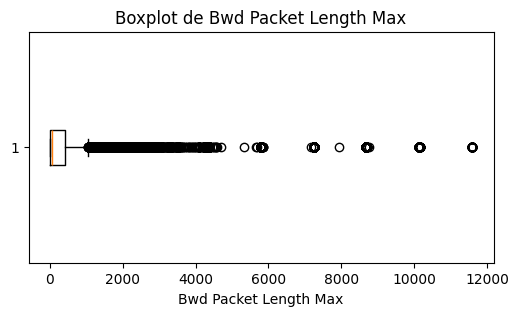

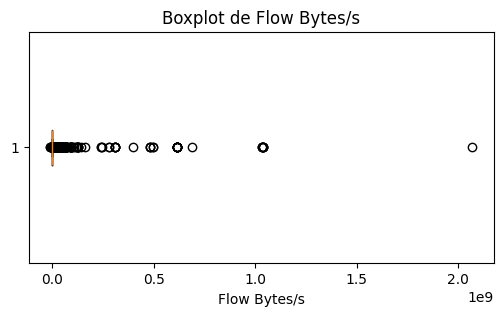

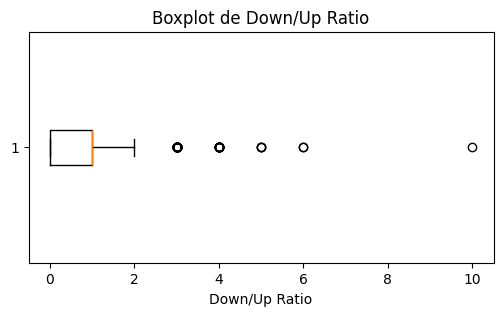

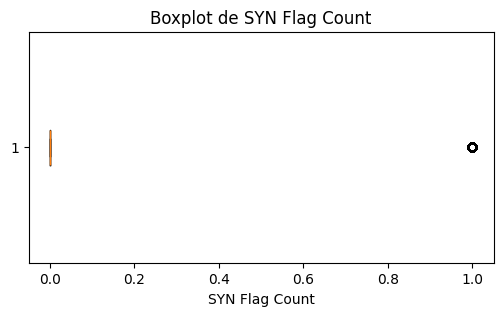

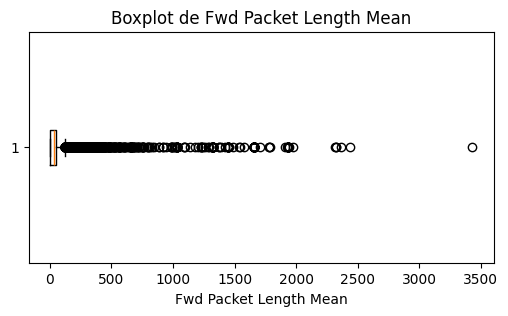

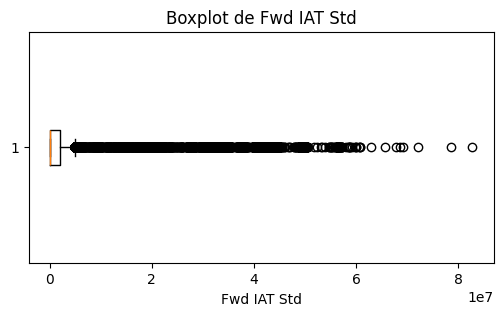

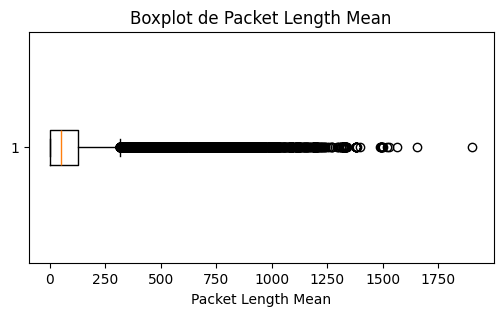

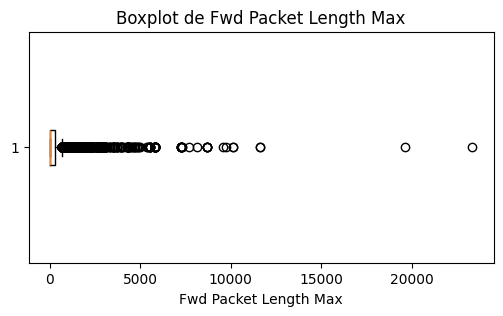

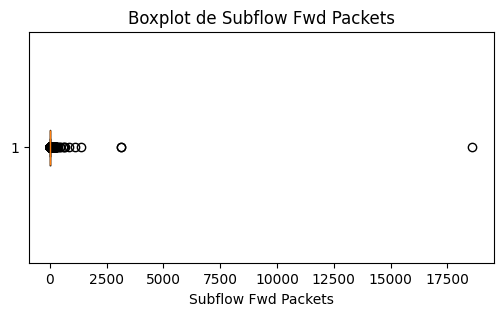

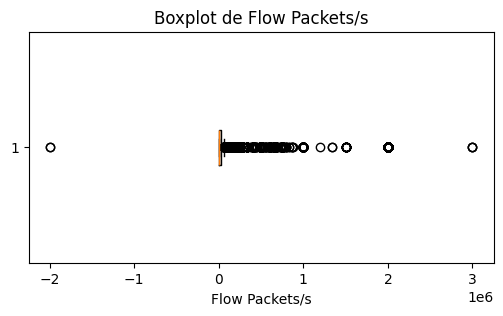

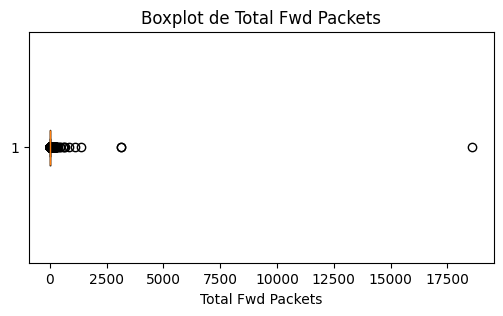

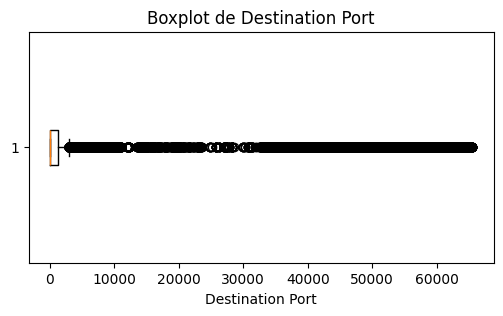

In [4]:
# To verify the presence of outliers we can visualize the data on matplotlib

numerical_cols = data.select_dtypes(include='number').columns

for col in numerical_cols[:-1]:
    plt.figure(figsize=(6,3))
    plt.boxplot(data[col], vert=False)  # vert=False pour horizontal
    plt.title(f'Boxplot de {col}')
    plt.xlabel(col)
    plt.show()

In [5]:

# Split label in var Y and features in X
X = data.drop(columns=['Label']).values
y = data['Label'].values

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=random_seed)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=random_seed)

# Standardize the features
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


 Task 2: Shallow Neural Network
 Design your first Neural Network.

In [6]:
# Define a FFNN modele

class Generalize_Deep_FFNN(nn.Module):

    def __init__(self, layer_sizes, activation="linear", 
                 use_batchnorm=False, use_noise=False, noise_std=0.01):
        super(Generalize_Deep_FFNN, self).__init__()
        self.use_batchnorm = use_batchnorm
        self.use_noise = use_noise
        self.noise_std = noise_std
        
        layers = []
        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
            if self.use_batchnorm and i < len(layer_sizes) - 2:
                layers.append(nn.BatchNorm1d(layer_sizes[i + 1]))
            if i < len(layer_sizes) - 2:
                if activation.lower() == "relu":
                    layers.append(nn.ReLU())
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        if self.training and self.use_noise and self.noise_std > 0:
            x = x + torch.randn_like(x) * self.noise_std
        return self.net(x)

def training_loop(model, train_loader, val_loader, train_dataset, val_dataset, device, optimizer, criterion, epoche_max=200, patience = 5, min_delta = None,):
    """
    Train the model for a specified number of epochs and track the training and validation losses.
    
    Args:
        model: The neural network model to be trained.
        train_loader: DataLoader for the training dataset.
        val_loader: DataLoader for the validation dataset.
        train_dataset: The entire training dataset.
        val_dataset: The entire validation dataset.
        device: Device to run the model on (CPU or GPU).
        optimizer: The optimization algorithm to use for updating model parameters.
        criterion: The loss function to use for computing the loss.
    
    Returns:
        None: The function plots the training and validation loss over the epochs.
    """
    # Record the start time
    start_time = time.time()
    
    # Define training parameters
    num_epochs = epoche_max

    train_losses = []
    val_losses = []

    best_val_loss = float('inf')
    trigger_times = 0     # how many epochs since last improvement
    best_model_state = None    
    # Training loop
    for epoch in range(num_epochs):  # Train for epochs
        train_loss = 0
        val_loss = 0
        model.train()  # Set model to training mode
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)  # Move batch to GPU
            optimizer.zero_grad()  # Clear previous gradients
            outputs = model(batch_X)  # Forward pass
            loss = criterion(outputs, batch_y)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update model parameters
            train_loss += loss.item() * batch_X.size(0)
        train_loss /= len(train_dataset)
        train_losses.append(train_loss)  # Store training loss

        # Compute Validation loss during training
        model.eval()  # Set model to evaluation mode
        with torch.no_grad():  # Disable gradient computation for validation
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)  # Move batch to GPU
                val_outputs = model(batch_X)  # Forward pass
                loss = criterion(val_outputs, batch_y)  # Compute validation loss
                val_loss += loss.item() * batch_X.size(0)
            val_loss /= len(val_dataset)
            val_losses.append(val_loss)  # Store validation loss        
        if (epoch + 1) % 20 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

        # ---- Early Stopping ----
        if(min_delta!= None):
            if val_loss < best_val_loss - min_delta:
                best_val_loss = val_loss
                best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
                trigger_times = 0
            else:
                trigger_times += 1
                if trigger_times >= patience:
                    print(f"Early stopping at epoch {epoch+1} (best val loss: {best_val_loss:.6f})")
                    break

    # Record the end time
    end_time = time.time()
    # Calculate the elapsed time
    elapsed_time = end_time - start_time
    print(f'The function took {elapsed_time:.4f} seconds to execute.')            
    return model, train_losses, val_losses


def testing_model(model, dataloader, device):
    """
    Evaluate the model on a given dataloader and compute accuracy.
    
    Args:
        model: The trained model.
        dataloader: DataLoader for the dataset.
        device: Device to run the model on (CPU or GPU).
    
    Returns:
        float: Accuracy of the model on the test dataset.
    """
    # Record the start time
    start_time = time.time()
   
    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():  # Disable gradient computation for efficiency
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  # Get the class with highest score
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_predictions) * 100
    
    # Print classification report
    print("\nClassification Report per class:")
    print(classification_report(all_labels, all_predictions, digits=4, zero_division=0))
    
    # Record the end time
    end_time = time.time()
    # Calculate the elapsed time
    elapsed_time = end_time - start_time
    print(f'The function took {elapsed_time:.4f} seconds to execute.')    
    
    return accuracy

def testing_models(models):
    for element in models:
        device = ChangeDeviceToCuda(element[0])
        accuracy = testing_model(element[0], test_loader, device)
        print(accuracy)

In [7]:
#Some functions to limit code duplication
def ChangeDeviceToCuda(model):
    # Use Cuda if GPU on your machine
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #No GPU on my machine :'(
    print(f"The device is set to: {device}")
    model = model.to(device)
    return device


def plot_models(models):
    plt.figure(figsize=(10, 6))
    for i, (model, train_loss, val_loss) in enumerate(models, start=1):
        plt.plot(train_loss, label=f"Train model {i}")
        plt.plot(val_loss, label=f"Val model {i}", linestyle='--')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Curves")
    plt.legend()
    plt.show()

def prep_loader(X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, X_test_tensor, y_test_tensor, batch_size=64):
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    
    train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

    return train_dataset, val_dataset, test_dataset, train_loader, val_loader, test_loader


def train_model(model, optimizer, batch_size, epoch_max, train_dataset, val_dataset, train_loader, val_loader, patience=5):
    # parameters for training
    criterion = nn.CrossEntropyLoss()

    # Use Cuda if GPU on your machine
    device = ChangeDeviceToCuda(model)

    #Launch the training_loop
    trained_model, train_loss, val_loss = training_loop(model, train_loader, val_loader, train_dataset, val_dataset, device, optimizer, criterion, epoch_max, patience)
    #Add the model to our list of model to compare parameters
    return (model, train_loss, val_loss)

def train_model_with_balancement(model, optimizer, batch_size, epoch_max, train_dataset, val_dataset, train_loader, val_loader, patience=5):
    # parameters for training
    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)
    # Use Cuda if GPU on your machine
    device = ChangeDeviceToCuda(model)
    class_weights_tensor = class_weights_tensor.to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

    #Launch the training_loop
    trained_model, train_loss, val_loss = training_loop(model, train_loader, val_loader, train_dataset, val_dataset, device, optimizer, criterion, epoch_max, patience)
    #Add the model to our list of model to compare parameters
    return (model, train_loss, val_loss)

def train_model_with_balancement_seconde_version(model, optimizer, batch_size, epoch_max, train_dataset, val_dataset, train_loader, val_loader, patience=5):
    # parameters for training
    class_counts = np.bincount(y_train)
    alpha = 0.5
    class_weights = (1.0 / class_counts) ** alpha
    class_weights = class_weights / class_weights.sum()
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)
    
    # Use Cuda if GPU on your machine
    device = ChangeDeviceToCuda(model)
    class_weights_tensor = class_weights_tensor.to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

    #Launch the training_loop
    trained_model, train_loss, val_loss = training_loop(model, train_loader, val_loader, train_dataset, val_dataset, device, optimizer, criterion, epoch_max, patience)
    #Add the model to our list of model to compare parameters
    return (model, train_loss, val_loss)

def test_plot_models(models):
    testing_models(models)
    plot_models(models)

    

Plot the loss curves during training on the training and validation set of the three models.
 What is their evolution? Do they converge?
 • How do you select the best model across epochs?
 • Focus and report the classification reports of the validation set of the three models.
 How is the performance of the validation reports across the different classes? Is the
 performance good or poor? Why?
 • Now, focus on the best model you chose. Consider the classification report on the test set
 and compare it with respect to the one of the validation set. Is the performance similar?
 I.e., does the model generalize?

 • Focus and report the classification report of the validation set. Does the model perform
 better in a specific class?
 • Would it be correct to compare the results on the test set?

The device is set to: cpu
Epoch 20/100, Train Loss: 0.3348, Val Loss: 0.3431
Epoch 40/100, Train Loss: 0.3167, Val Loss: 0.3190
Epoch 60/100, Train Loss: 0.3067, Val Loss: 0.3069
Epoch 80/100, Train Loss: 0.2994, Val Loss: 0.2970
Epoch 100/100, Train Loss: 0.2939, Val Loss: 0.2879
The function took 24.3425 seconds to execute.
The device is set to: cpu
Epoch 20/100, Train Loss: 0.3260, Val Loss: 0.3287
Epoch 40/100, Train Loss: 0.3085, Val Loss: 0.3037
Epoch 60/100, Train Loss: 0.2994, Val Loss: 0.2958
Epoch 80/100, Train Loss: 0.2937, Val Loss: 0.2912
Epoch 100/100, Train Loss: 0.2882, Val Loss: 0.2799
The function took 21.1029 seconds to execute.
The device is set to: cpu
Epoch 20/100, Train Loss: 0.3198, Val Loss: 0.3185
Epoch 40/100, Train Loss: 0.3041, Val Loss: 0.3031
Epoch 60/100, Train Loss: 0.2960, Val Loss: 0.2953
Epoch 80/100, Train Loss: 0.2890, Val Loss: 0.2752
Epoch 100/100, Train Loss: 0.2850, Val Loss: 0.2707
The function took 21.7167 seconds to execute.
The device is se

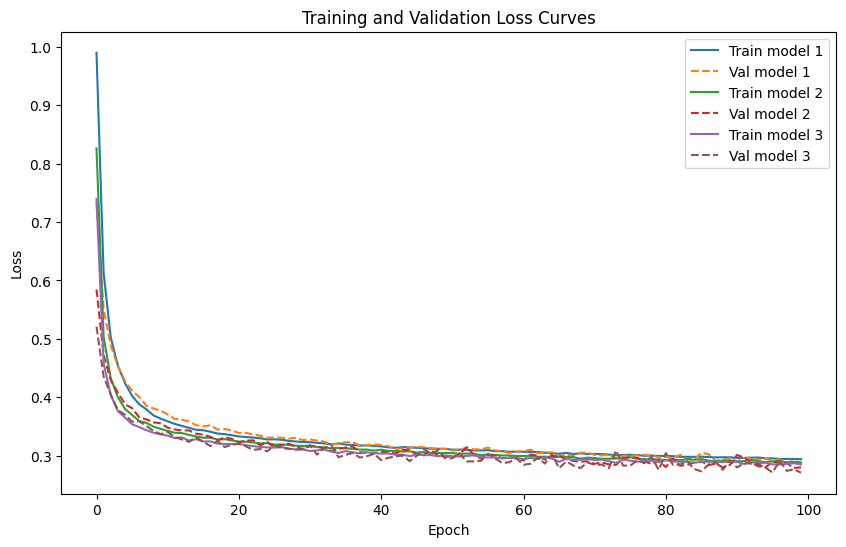

In [8]:
def Activity_one(architectures, batch_size, train_loader, val_loader, train_dataset, val_dataset, epoch_max=100, activation_fct="linear"):
    models = []
    for architecture in architectures:
        model = Generalize_Deep_FFNN(architecture, activation_fct)
        optimizer = optim.Adam(model.parameters(), lr=0.0005)
        models.append(train_model(model, optimizer, batch_size, epoch_max, train_dataset, val_dataset, train_loader, val_loader))
    
    test_plot_models(models)

input_len = X_train_tensor.shape[1]
output_len = len(np.unique(y_train_tensor))

# FFNN parameters
architectures = [[input_len, 32, output_len],
    [input_len, 64, output_len],
    [input_len, 128, output_len]]

batch_size = 64

#test_loader
train_dataset, val_dataset, test_dataset, train_loader, val_loader, test_loader = prep_loader(X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, X_test_tensor, y_test_tensor, batch_size)
Activity_one(architectures, batch_size, train_loader, val_loader, train_dataset, val_dataset, activation_fct="linear")

The device is set to: cpu
Epoch 20/100, Train Loss: 0.1816, Val Loss: 0.1836
Epoch 40/100, Train Loss: 0.1555, Val Loss: 0.1571
Epoch 60/100, Train Loss: 0.1429, Val Loss: 0.1462
Epoch 80/100, Train Loss: 0.1341, Val Loss: 0.1367
Epoch 100/100, Train Loss: 0.1277, Val Loss: 0.1268
The function took 21.2211 seconds to execute.
The device is set to: cpu
Epoch 20/100, Train Loss: 0.1677, Val Loss: 0.1692
Epoch 40/100, Train Loss: 0.1434, Val Loss: 0.1434
Epoch 60/100, Train Loss: 0.1312, Val Loss: 0.1300
Epoch 80/100, Train Loss: 0.1230, Val Loss: 0.1226
Epoch 100/100, Train Loss: 0.1177, Val Loss: 0.1161
The function took 22.1555 seconds to execute.
The device is set to: cpu
Epoch 20/100, Train Loss: 0.1551, Val Loss: 0.1543
Epoch 40/100, Train Loss: 0.1334, Val Loss: 0.1313
Epoch 60/100, Train Loss: 0.1221, Val Loss: 0.1184
Epoch 80/100, Train Loss: 0.1148, Val Loss: 0.1106
Epoch 100/100, Train Loss: 0.1091, Val Loss: 0.1053
The function took 25.5778 seconds to execute.
The device is se

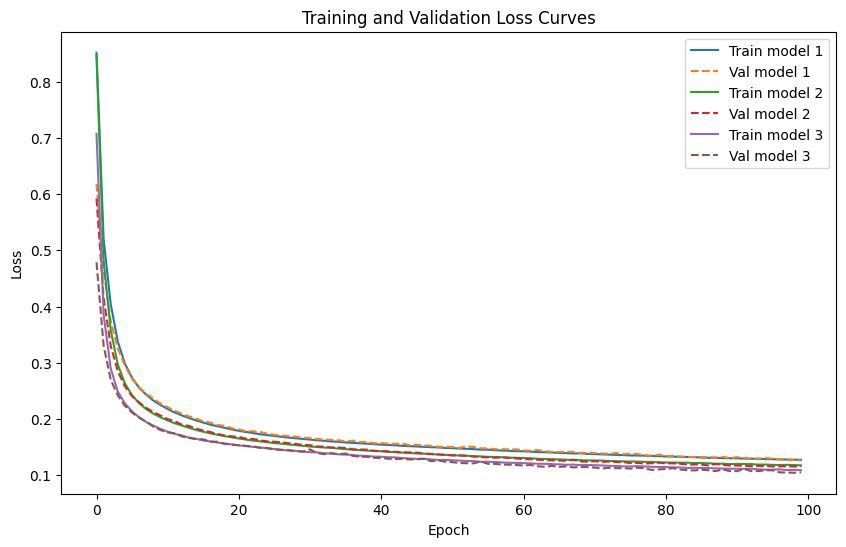

In [9]:

Activity_one(architectures, batch_size, train_loader, val_loader, train_dataset, val_dataset, activation_fct="relu")


 Task 3: The impact of Specific Features

 • Is this a reasonable assumption?
 • Replace port 80 with port 8080 for the Brute Force attacks in the Test set. Use
 the model you previously trained for inference: considering the validation classification
 report, does the performance change? How does it change? Why?

In [10]:

# Split label in var Y and features in X
X = data.drop(columns=['Label']).values
y = data['Label'].values

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=random_seed)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=random_seed)

#Modify only X_test
label_bruteforce = list(label_encoder.classes_).index("Brute Force")
mask_test  = (y_test == label_bruteforce)

X_test[mask_test][X_test[mask_test] == 80] = 8080


# Standardize the features
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


The device is set to: cpu
Epoch 20/100, Train Loss: 0.1559, Val Loss: 0.1585
Epoch 40/100, Train Loss: 0.1347, Val Loss: 0.1348
Epoch 60/100, Train Loss: 0.1228, Val Loss: 0.1220
Epoch 80/100, Train Loss: 0.1164, Val Loss: 0.1130
Epoch 100/100, Train Loss: 0.1100, Val Loss: 0.1117
The function took 24.8203 seconds to execute.
The device is set to: cpu

Classification Report per class:
              precision    recall  f1-score   support

           0     0.9581    0.9733    0.9657      3856
           1     0.7844    0.9508    0.8596       264
           2     0.9892    0.9120    0.9491       807
           3     0.9554    0.9012    0.9275       951

    accuracy                         0.9522      5878
   macro avg     0.9218    0.9343    0.9254      5878
weighted avg     0.9542    0.9522    0.9524      5878

The function took 0.0354 seconds to execute.
95.21946240217761


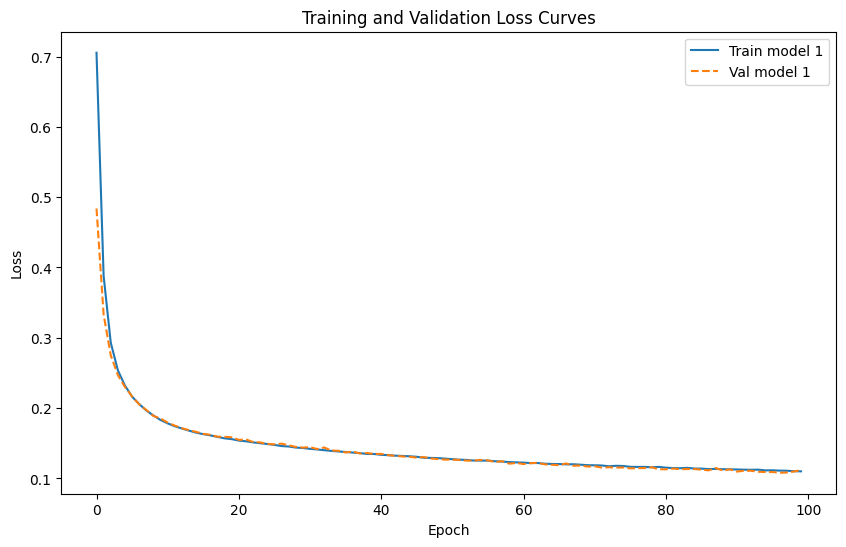

In [11]:

input_len = X_train_tensor.shape[1]
output_len = len(np.unique(y_train_tensor))

# FFNN parameters
architectures = [[input_len, 128, output_len]]

# Same test as before after changing the port on Brute Force attack
train_dataset, val_dataset, test_dataset, train_loader, val_loader, test_loader = prep_loader(X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, X_test_tensor, y_test_tensor, batch_size)
Activity_one(architectures, batch_size, train_loader, val_loader, train_dataset, val_dataset, activation_fct="relu")


 How many PortScan do you now have after preprocessing (e.g., removing duplicates)?
 How many did you have before?
 • Why do you think PortScan is the most affected class after dropping the duplicates?
 • Are the classes now balanced?

In [12]:
data = pd.read_csv("dataset_lab_1.csv")
# Count PortScan BEFORE preprocessing
portscan_before = data[data["Label"] == "PortScan"].shape[0]
print("PortScan count before preprocessing:", portscan_before)

print("Number of rows in the raw dataset:", len(data))
# Replace infinite values
data = data.replace([np.inf, -np.inf], np.nan)

# Drop missing values
data = data.dropna()

# Drop duplicates (first pass)
data = data.drop_duplicates()
print("Number of rows after removing missing values and duplicates:", len(data))

# Count PortScan after first duplicate removal
portscan_after_first = data[data["Label"] == "PortScan"].shape[0]
print("PortScan count after first duplicate removal:", portscan_after_first)

# Remove Destination Port and drop duplicates again
print("Rows before removing Destination Port column:", len(data))
data = data.drop(columns=["Destination Port"])
data = data.drop_duplicates()
print("Rows after removing duplicates (final):", len(data))

# Count PortScan AFTER final preprocessing
portscan_after = data[data["Label"] == "PortScan"].shape[0]
print("PortScan count after full preprocessing:", portscan_after)

class_counts = data["Label"].value_counts()
print("\nClass distribution after preprocessing:\n", class_counts)

label_encoder = LabelEncoder()
data["Label"] = label_encoder.fit_transform(data["Label"])

X = data.drop(columns=["Label"]).values
y = data["Label"].values

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=random_seed)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=random_seed)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


PortScan count before preprocessing: 5000
Number of rows in the raw dataset: 31507
Number of rows after removing missing values and duplicates: 29386
PortScan count after first duplicate removal: 4849
Rows before removing Destination Port column: 29386
Rows after removing duplicates (final): 22469
PortScan count after full preprocessing: 285

Class distribution after preprocessing:
 Label
Benign         16889
DoS Hulk        3868
Brute Force     1427
PortScan         285
Name: count, dtype: int64


The device is set to: cpu
Epoch 20/100, Train Loss: 0.1574, Val Loss: 0.1560
Epoch 40/100, Train Loss: 0.1338, Val Loss: 0.1364
Epoch 60/100, Train Loss: 0.1241, Val Loss: 0.1260
Epoch 80/100, Train Loss: 0.1177, Val Loss: 0.1198
Epoch 100/100, Train Loss: 0.1133, Val Loss: 0.1154
The function took 19.9822 seconds to execute.
The device is set to: cpu

Classification Report per class:
              precision    recall  f1-score   support

           0     0.9730    0.9770    0.9750      3397
           1     0.8232    0.9343    0.8752       274
           2     0.9916    0.9172    0.9530       773
           3     0.4386    0.5000    0.4673        50

    accuracy                         0.9588      4494
   macro avg     0.8066    0.8321    0.8176      4494
weighted avg     0.9611    0.9588    0.9595      4494

The function took 0.0311 seconds to execute.
95.88340008900757


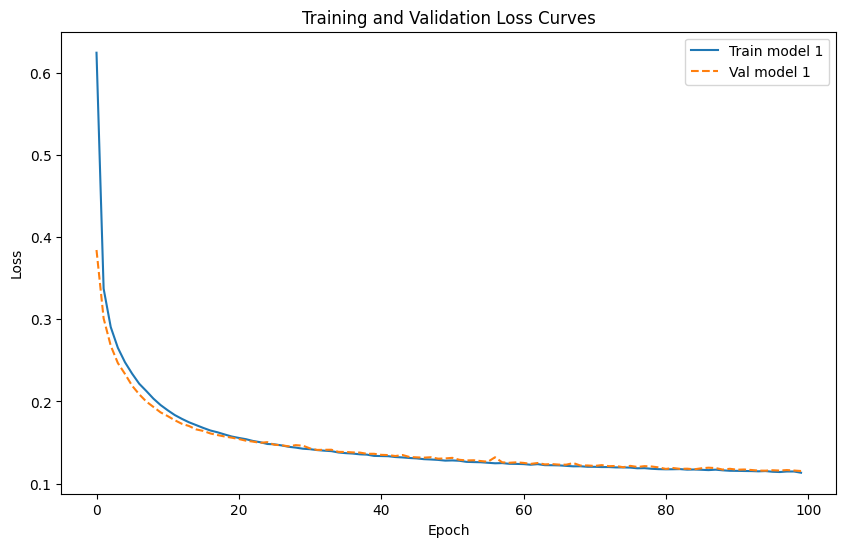

In [13]:
input_len = X_train_tensor.shape[1]
output_len = len(np.unique(y_train_tensor))

# FFNN parameters
architectures = [[input_len, 128, output_len]]

# Same test as before after changing the port on Brute Force attack
train_dataset, val_dataset, test_dataset, train_loader, val_loader, test_loader = prep_loader(X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, X_test_tensor, y_test_tensor, batch_size)
Activity_one(architectures, batch_size, train_loader, val_loader, train_dataset, val_dataset, activation_fct="relu")


Task 4: The impact of the Loss Function

• How does the performance change? Can you still classify the rarest class?
 • Which partition do you use to estimate the class weights?
 Now, repeat the training process with the new loss:
 • How does the performance change per class and overall? In particular, how does the
 accuracy change? How does the f1 score change?

The device is set to: cpu
Epoch 20/100, Train Loss: 0.2623, Val Loss: 0.2584
Epoch 40/100, Train Loss: 0.2319, Val Loss: 0.2140
Epoch 60/100, Train Loss: 0.2139, Val Loss: 0.1903
Epoch 80/100, Train Loss: 0.2002, Val Loss: 0.1768
Epoch 100/100, Train Loss: 0.1975, Val Loss: 0.1752
The function took 20.6226 seconds to execute.
The device is set to: cpu

Classification Report per class:
              precision    recall  f1-score   support

           0     0.9905    0.9176    0.9526      3397
           1     0.7835    0.9380    0.8538       274
           2     0.9209    0.9340    0.9274       773
           3     0.2043    0.9600    0.3368        50

    accuracy                         0.9221      4494
   macro avg     0.7248    0.9374    0.7677      4494
weighted avg     0.9571    0.9221    0.9354      4494

The function took 0.0376 seconds to execute.
92.21183800623052


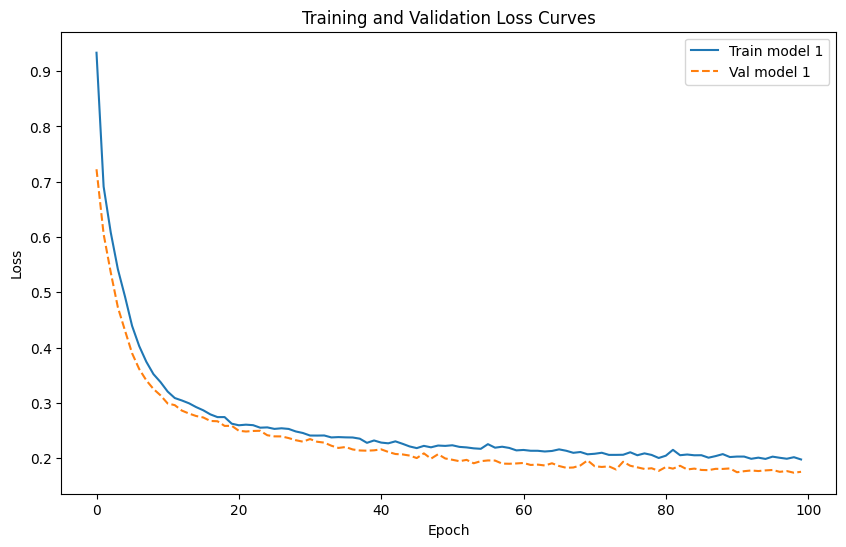

The device is set to: cpu
Epoch 20/100, Train Loss: 0.2299, Val Loss: 0.2232
Epoch 40/100, Train Loss: 0.1993, Val Loss: 0.1883
Epoch 60/100, Train Loss: 0.1854, Val Loss: 0.1701
Epoch 80/100, Train Loss: 0.1779, Val Loss: 0.1635
Epoch 100/100, Train Loss: 0.1720, Val Loss: 0.1599
The function took 20.0140 seconds to execute.
The device is set to: cpu

Classification Report per class:
              precision    recall  f1-score   support

           0     0.9862    0.9500    0.9678      3397
           1     0.7975    0.9343    0.8605       274
           2     0.9327    0.9508    0.9417       773
           3     0.4071    0.9200    0.5644        50

    accuracy                         0.9488      4494
   macro avg     0.7809    0.9388    0.8336      4494
weighted avg     0.9591    0.9488    0.9523      4494

The function took 0.0281 seconds to execute.
94.88206497552292


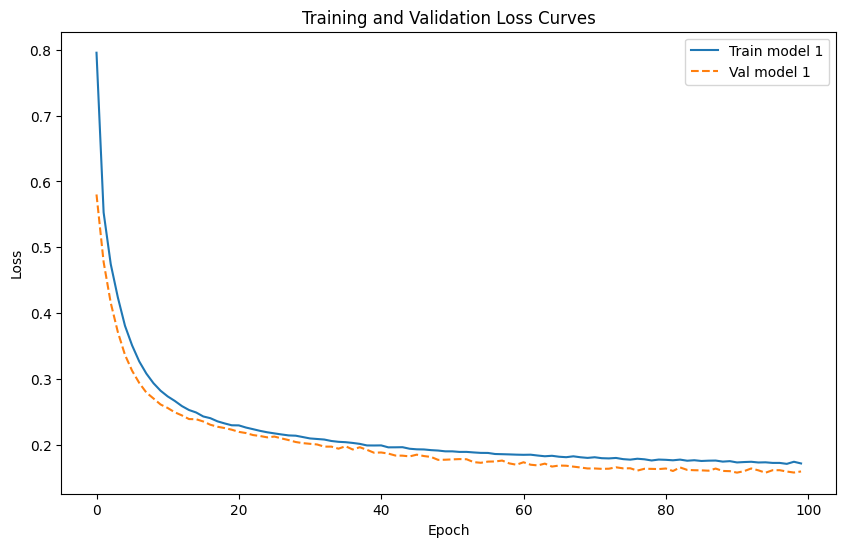

In [14]:
def Activity_one_bis(architectures, batch_size, train_loader, val_loader, train_dataset, val_dataset, epoch_max=100, activation_fct="linear"):
    """
    Same as activity one but with a weigth
    """
    models = []
    for architecture in architectures:
        model = Generalize_Deep_FFNN(architecture, activation_fct)
        optimizer = optim.Adam(model.parameters(), lr=0.0005)
        models.append(train_model_with_balancement(model, optimizer, batch_size, epoch_max, train_dataset, val_dataset, train_loader, val_loader))
    
    test_plot_models(models)

def Activity_one_bis2(architectures, batch_size, train_loader, val_loader, train_dataset, val_dataset, epoch_max=100, activation_fct="linear"):
    """
    Same as activity one but with another weigthed version
    """
    models = []
    for architecture in architectures:
        model = Generalize_Deep_FFNN(architecture, activation_fct)
        optimizer = optim.Adam(model.parameters(), lr=0.0005)
        models.append(train_model_with_balancement_seconde_version(model, optimizer, batch_size, epoch_max, train_dataset, val_dataset, train_loader, val_loader))
    
    test_plot_models(models)

input_len = X_train_tensor.shape[1]
output_len = len(np.unique(y_train_tensor))

# FFNN parameters
architectures = [[input_len, 128, output_len]]

# Same test as before after changing the port on Brute Force attack
train_dataset, val_dataset, test_dataset, train_loader, val_loader, test_loader = prep_loader(X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, X_test_tensor, y_test_tensor, batch_size)
Activity_one_bis(architectures, batch_size, train_loader, val_loader, train_dataset, val_dataset, activation_fct="relu")
Activity_one_bis2(architectures, batch_size, train_loader, val_loader, train_dataset, val_dataset, activation_fct="relu")


The device is set to: cpu
Epoch 20/100, Train Loss: 0.2546, Val Loss: 0.2470
Epoch 40/100, Train Loss: 0.1808, Val Loss: 0.1798
Epoch 60/100, Train Loss: 0.1627, Val Loss: 0.1677
Epoch 80/100, Train Loss: 0.1549, Val Loss: 0.1617
Epoch 100/100, Train Loss: 0.1494, Val Loss: 0.1564
The function took 23.7793 seconds to execute.
The device is set to: cpu
Epoch 20/100, Train Loss: 0.1462, Val Loss: 0.1441
Epoch 40/100, Train Loss: 0.1197, Val Loss: 0.1188
Epoch 60/100, Train Loss: 0.1065, Val Loss: 0.1059
Epoch 80/100, Train Loss: 0.0987, Val Loss: 0.0987
Epoch 100/100, Train Loss: 0.0935, Val Loss: 0.0930
The function took 20.4169 seconds to execute.
The device is set to: cpu
Epoch 20/100, Train Loss: 0.3396, Val Loss: 0.3338
Epoch 40/100, Train Loss: 0.2625, Val Loss: 0.2664
Epoch 60/100, Train Loss: 0.2389, Val Loss: 0.2426
Epoch 80/100, Train Loss: 0.2281, Val Loss: 0.2290
Epoch 100/100, Train Loss: 0.2224, Val Loss: 0.2258
The function took 22.7421 seconds to execute.
The device is se

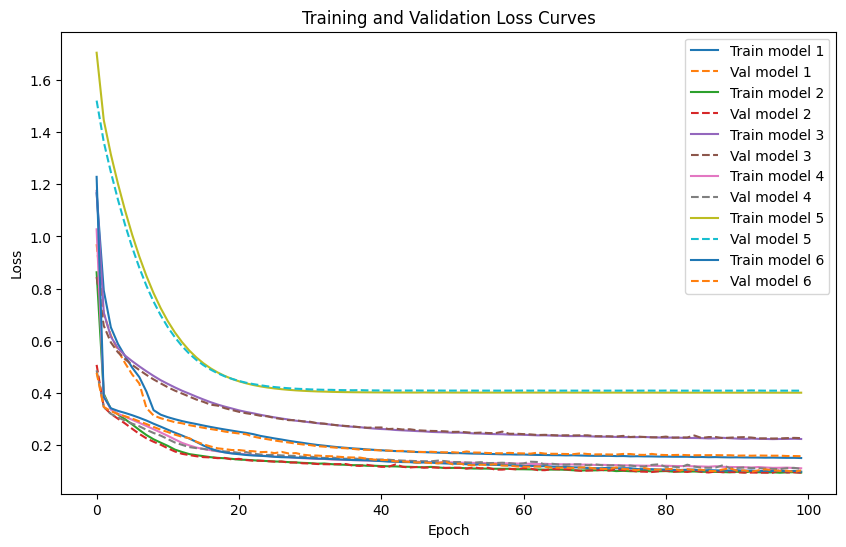

In [15]:
input_len = X_train_tensor.shape[1]
output_len = len(np.unique(y_train_tensor))

# FFNN parameters
architectures = [
    [input_len, 8, 4, 2, output_len],
    [input_len, 32, 16, 8, output_len],
    [input_len, 16, 8, 4, 2, output_len],
    [input_len, 32, 16, 8, 4, output_len],
    [input_len, 32, 16, 8, 4, 2, output_len],
    [input_len, 32, 32, 16, 8, 4, output_len]
]

train_dataset, val_dataset, test_dataset, train_loader, val_loader, test_loader = prep_loader(X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, X_test_tensor, y_test_tensor, batch_size)
Activity_one(architectures, batch_size, train_loader, val_loader, train_dataset, val_dataset, epoch_max=100, activation_fct="relu")


The device is set to: cpu
Epoch 20/100, Train Loss: 0.2245, Val Loss: 0.2221
Epoch 40/100, Train Loss: 0.1427, Val Loss: 0.1450
Epoch 60/100, Train Loss: 0.1208, Val Loss: 0.1203
Epoch 80/100, Train Loss: 0.1128, Val Loss: 0.1147
Epoch 100/100, Train Loss: 0.1101, Val Loss: 0.1080
The function took 21.0376 seconds to execute.
The device is set to: cpu
Epoch 20/100, Train Loss: 0.1992, Val Loss: 0.1967
Epoch 40/100, Train Loss: 0.1545, Val Loss: 0.1617
Epoch 60/100, Train Loss: 0.1354, Val Loss: 0.1462
Epoch 80/100, Train Loss: 0.1270, Val Loss: 0.1381
Epoch 100/100, Train Loss: 0.1189, Val Loss: 0.1576
The function took 21.4481 seconds to execute.
The device is set to: cpu
Epoch 20/100, Train Loss: 0.1938, Val Loss: 0.1941
Epoch 40/100, Train Loss: 0.1436, Val Loss: 0.1455
Epoch 60/100, Train Loss: 0.1181, Val Loss: 0.1204
Epoch 80/100, Train Loss: 0.1089, Val Loss: 0.1161
Epoch 100/100, Train Loss: 0.1048, Val Loss: 0.1069
The function took 21.0441 seconds to execute.
The device is se

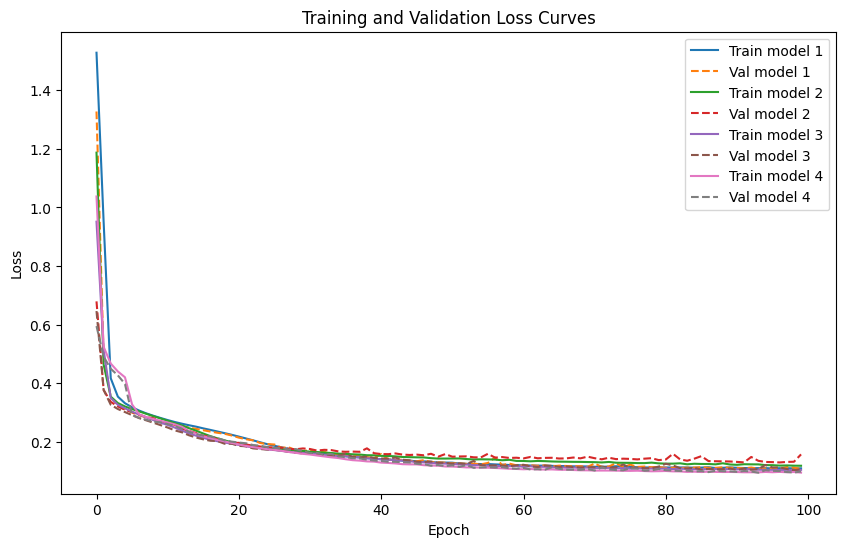

In [16]:
batch_sizes = [4, 64, 256, 1024]
best_architecture = [input_len, 32, 16, 8, 4, output_len] #set after the previous experimentation

def Activity_two(architecture, batch_sizes, train_loader, val_loader, train_dataset, val_dataset, epoch_max=50, activation_fct="relu"):
    models = []
    for element in batch_sizes:
        model = Generalize_Deep_FFNN(architecture, activation_fct)
        optimizer = optim.Adam(model.parameters(), lr=0.0005)
        models.append(train_model(model, optimizer, batch_size, epoch_max, train_dataset, val_dataset, train_loader, val_loader))
    
    test_plot_models(models)
        
Activity_two(best_architecture, batch_sizes, train_loader, val_loader, train_dataset, val_dataset, epoch_max=100, activation_fct="relu")

 The impact of the Optimizer

 • Is there a difference in the trend of the loss functions?
 • How long does it take to train the models with the different optimizers? And why?
 Now, focus on the architecture with the best optimizer.
 • Evaluate the effects of the different learning rates and epochs. Report the test results for
 the best model.

The device is set to: cpu
Epoch 20/100, Train Loss: 0.9521, Val Loss: 0.9573
Epoch 40/100, Train Loss: 0.8410, Val Loss: 0.8509
Epoch 60/100, Train Loss: 0.7966, Val Loss: 0.8072
Epoch 80/100, Train Loss: 0.7585, Val Loss: 0.7676
Epoch 100/100, Train Loss: 0.6432, Val Loss: 0.6428
The function took 16.5959 seconds to execute.
The device is set to: cpu
Epoch 20/100, Train Loss: 0.9262, Val Loss: 0.9276
Epoch 40/100, Train Loss: 0.8099, Val Loss: 0.8180
Epoch 60/100, Train Loss: 0.7787, Val Loss: 0.7882
Epoch 80/100, Train Loss: 0.7671, Val Loss: 0.7763
Epoch 100/100, Train Loss: 0.7610, Val Loss: 0.7697
The function took 16.6916 seconds to execute.
The device is set to: cpu
Epoch 20/100, Train Loss: 0.7756, Val Loss: 0.7822
Epoch 40/100, Train Loss: 0.7351, Val Loss: 0.7421
Epoch 60/100, Train Loss: 0.6466, Val Loss: 0.6458
Epoch 80/100, Train Loss: 0.4471, Val Loss: 0.4430
Epoch 100/100, Train Loss: 0.3875, Val Loss: 0.3807
The function took 17.2017 seconds to execute.
The device is se

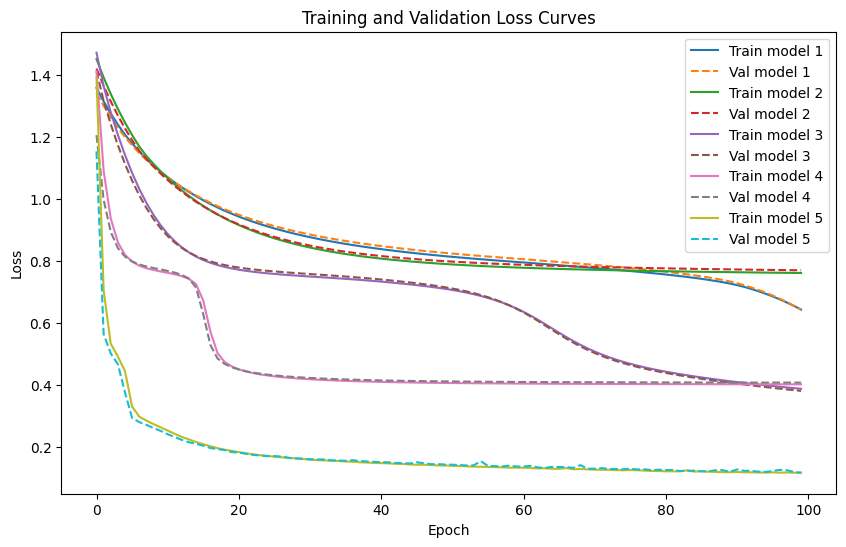

In [17]:
best_batchsize = 64
optimizers = [lambda params: optim.SGD(params, lr=0.0005), lambda params: optim.SGD(params, lr=0.0005, momentum=0.1), lambda params: optim.SGD(params, lr=0.0005, momentum=0.5), lambda params: optim.SGD(params, lr=0.0005, momentum=0.9), lambda params: optim.AdamW(params, lr=0.0005)]

def Activity_three(architecture, batch_size, train_loader, val_loader, train_dataset, val_dataset, optimizers, epoch_max=50, activation_fct="relu"):
    models = []
    for opt_builder in optimizers:
        model = Generalize_Deep_FFNN(architecture, activation_fct)
        optimizer = opt_builder(model.parameters())
        trained_model = train_model(model, optimizer, batch_size, epoch_max, train_dataset, val_dataset, train_loader, val_loader)
        models.append(trained_model)
    test_plot_models(models)

Activity_three(best_architecture, best_batchsize, train_loader, val_loader, train_dataset, val_dataset, optimizers, epoch_max=100, activation_fct="relu")


The device is set to: cpu
Epoch 20/100, Train Loss: 0.1265, Val Loss: 0.1328
Epoch 40/100, Train Loss: 0.1180, Val Loss: 0.1047
Epoch 60/100, Train Loss: 0.1323, Val Loss: 0.1250
Epoch 80/100, Train Loss: 0.1217, Val Loss: 0.1290
Epoch 100/100, Train Loss: 0.1178, Val Loss: 0.1198
The function took 21.6549 seconds to execute.
The device is set to: cpu
Epoch 20/100, Train Loss: 0.1446, Val Loss: 0.1365
Epoch 40/100, Train Loss: 0.1261, Val Loss: 0.1465
Epoch 60/100, Train Loss: 0.1173, Val Loss: 0.1156
Epoch 80/100, Train Loss: 0.1248, Val Loss: 0.1531
Epoch 100/100, Train Loss: 0.1147, Val Loss: 0.1116
The function took 22.4271 seconds to execute.
The device is set to: cpu
Epoch 20/100, Train Loss: 0.1428, Val Loss: 0.1500
Epoch 40/100, Train Loss: 0.1155, Val Loss: 0.1137
Epoch 60/100, Train Loss: 0.0995, Val Loss: 0.0999
Epoch 80/100, Train Loss: 0.0946, Val Loss: 0.1079
Epoch 100/100, Train Loss: 0.0959, Val Loss: 0.0921
The function took 21.3893 seconds to execute.
The device is se

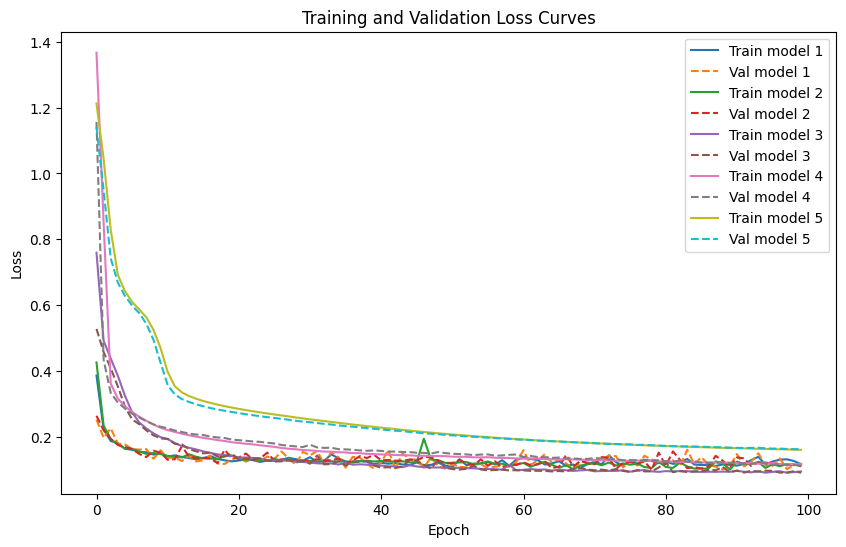

In [18]:
optimizers = [lambda p, lr=lr: optim.AdamW(p, lr=lr) for lr in [0.01, 0.005, 0.001, 0.0005, 0.0001]]
Activity_three(best_architecture, batch_size, train_loader, val_loader, train_dataset, val_dataset, optimizers, epoch_max=100, activation_fct="relu")


Task 6: Overfitting and Regularization

• What do the losses look like? Is the model overfitting?
 Now apply normalization techniques (dropout, batch normalization) and play with the
 regularization of the weights (AdamW’s weight decay).
 • What impact do the different normalization techniques have on validation and testing
 performance?


The device is set to: cpu
The function took 2.0033 seconds to execute.
The device is set to: cpu
Epoch 20/50, Train Loss: 0.1310, Val Loss: 0.1219
Epoch 40/50, Train Loss: 0.1083, Val Loss: 0.1154
The function took 9.9981 seconds to execute.
The device is set to: cpu
Epoch 20/100, Train Loss: 0.7503, Val Loss: 0.7545
Epoch 40/100, Train Loss: 0.7503, Val Loss: 0.7545
Epoch 60/100, Train Loss: 0.7503, Val Loss: 0.7546
Epoch 80/100, Train Loss: 0.7503, Val Loss: 0.7557
Epoch 100/100, Train Loss: 0.7503, Val Loss: 0.7550
The function took 21.8679 seconds to execute.
The device is set to: cpu
Epoch 20/200, Train Loss: 0.1131, Val Loss: 0.1273
Epoch 40/200, Train Loss: 0.1011, Val Loss: 0.1040
Epoch 60/200, Train Loss: 0.0913, Val Loss: 0.0988
Epoch 80/200, Train Loss: 0.1040, Val Loss: 0.0984
Epoch 100/200, Train Loss: 0.0976, Val Loss: 0.1139
Epoch 120/200, Train Loss: 0.0828, Val Loss: 0.1075
Epoch 140/200, Train Loss: 0.0874, Val Loss: 0.1046
Epoch 160/200, Train Loss: 0.0821, Val Loss:

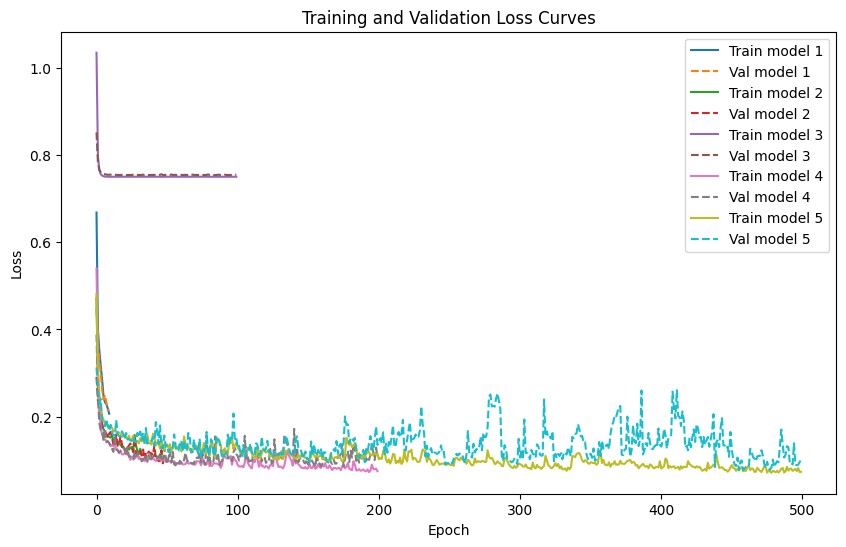

In [19]:
best_learning_rate =0.001

epochs_list = [10, 50, 100, 200, 500]

def Activity_four(architecture, batch_size, train_loader, val_loader, train_dataset, val_dataset, epoch_list, activation_fct="relu"):
    models = []
    for element in epoch_list:
        model =  Generalize_Deep_FFNN(architecture, activation_fct)
        optimizer = optim.Adam(model.parameters(), lr=0.005)
        models.append(train_model(model, optimizer, batch_size, element, train_dataset, val_dataset, train_loader, val_loader))
    test_plot_models(models)  


Activity_four(best_architecture, 64, train_loader, val_loader, train_dataset, val_dataset, epochs_list, activation_fct="relu")

best_epochs_list = 100


The device is set to: cpu
Epoch 20/50, Train Loss: 0.1179, Val Loss: 0.1123
Epoch 40/50, Train Loss: 0.1059, Val Loss: 0.1079
The function took 17.8493 seconds to execute.
The device is set to: cpu

Classification Report per class:
              precision    recall  f1-score   support

           0     0.9707    0.9853    0.9779      3397
           1     0.8380    0.9818    0.9042       274
           2     0.9971    0.8823    0.9362       773
           3     0.7805    0.6400    0.7033        50

    accuracy                         0.9635      4494
   macro avg     0.8966    0.8723    0.8804      4494
weighted avg     0.9650    0.9635    0.9632      4494

The function took 0.0432 seconds to execute.
96.35068980863373


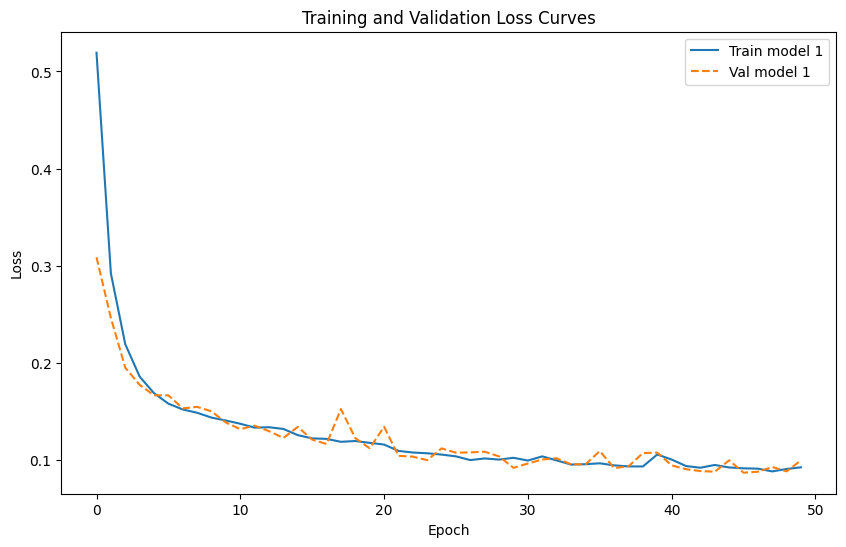

In [20]:
# FFNN parameters
architecture = [input_len, 256, 128, 64, 32, 16, output_len]
batch_size = 128

def Activity_five(architecture, batch_size, train_loader, val_loader, train_dataset, val_dataset, optimizers, epoch_max=50, activation_fct="relu", patience=50):
    models = []    
    model = Generalize_Deep_FFNN(architecture, activation_fct)
    optimizer = optim.Adam(model.parameters(), lr=0.0005)
    trained_model = train_model(model, optimizer, batch_size, epoch_max, train_dataset, val_dataset, train_loader, val_loader, patience=50)
    models.append(trained_model)
    test_plot_models(models)

Activity_five(architecture, batch_size, train_loader, val_loader, train_dataset, val_dataset, optimizers, epoch_max=50, activation_fct="relu", patience=50)



The device is set to: cpu
Epoch 20/50, Train Loss: 0.1224, Val Loss: 0.4852
Epoch 40/50, Train Loss: 0.1074, Val Loss: 0.6421
The function took 22.1853 seconds to execute.
The device is set to: cpu

Classification Report per class:
              precision    recall  f1-score   support

           0     0.8943    0.9991    0.9438      3397
           1     1.0000    0.0730    0.1361       274
           2     0.9971    0.8745    0.9318       773
           3     0.0000    0.0000    0.0000        50

    accuracy                         0.9101      4494
   macro avg     0.7228    0.4867    0.5029      4494
weighted avg     0.9085    0.9101    0.8820      4494

The function took 0.0345 seconds to execute.
91.01023587004894


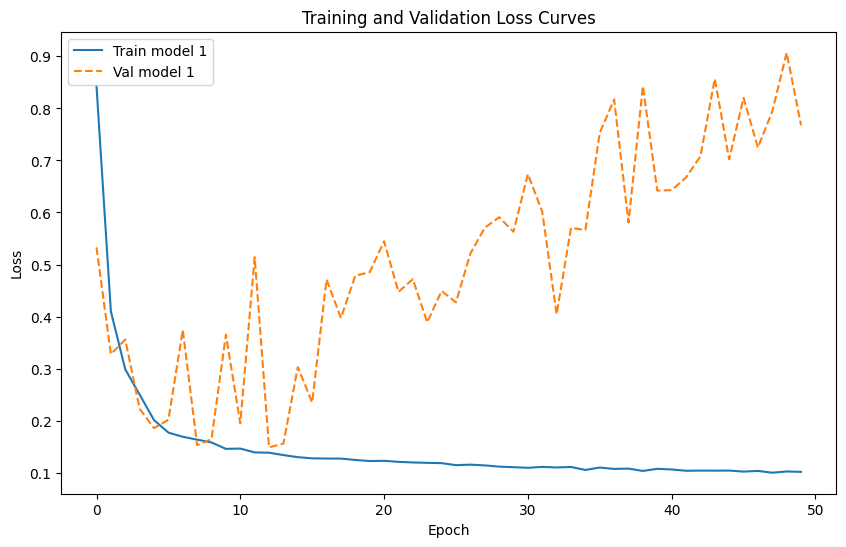

In [21]:

def Activity_six(architecture, batch_size, train_loader, val_loader, train_dataset, val_dataset, optimizers, epoch_max=50, activation_fct="relu", patience=50, use_batchnorm=False):
    models = []
    model = Generalize_Deep_FFNN(architecture, activation_fct, use_batchnorm=use_batchnorm)
    optimizer = optim.Adam(model.parameters(), lr=0.0005)
    trained_model = train_model(model, optimizer, batch_size, epoch_max, train_dataset, val_dataset, train_loader, val_loader, patience=patience)
    models.append(trained_model)
    test_plot_models(models)

Activity_six(architecture, batch_size, train_loader, val_loader, train_dataset, val_dataset, optimizers, epoch_max=50, activation_fct="relu", patience=50, use_batchnorm=True)



The device is set to: cpu
Epoch 20/50, Train Loss: 0.1228, Val Loss: 0.1160
Epoch 40/50, Train Loss: 0.1046, Val Loss: 0.1025
The function took 21.4372 seconds to execute.
The device is set to: cpu

Classification Report per class:
              precision    recall  f1-score   support

           0     0.9763    0.9841    0.9802      3397
           1     0.9110    0.9343    0.9225       274
           2     0.9889    0.9224    0.9545       773
           3     0.4706    0.6400    0.5424        50

    accuracy                         0.9666      4494
   macro avg     0.8367    0.8702    0.8499      4494
weighted avg     0.9689    0.9666    0.9674      4494

The function took 0.0317 seconds to execute.
96.66221628838451


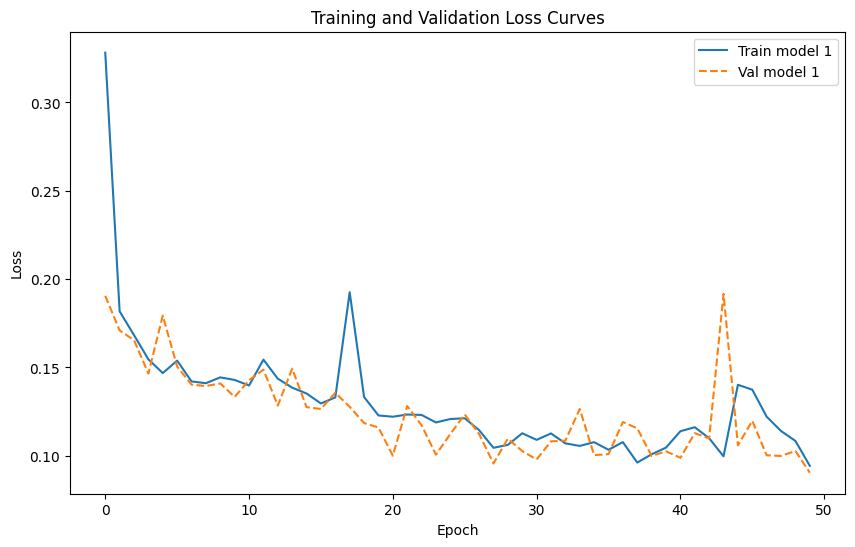

In [22]:

def Activity_seven(architecture, batch_size, train_loader, val_loader, train_dataset, val_dataset, optimizers, epoch_max=50, activation_fct="relu", patience=50, use_batchnorm=False):
    models = []
    model = Generalize_Deep_FFNN(layer_sizes=architecture, activation="relu", use_batchnorm=False, use_noise=True, noise_std=0)
    optimizer = optim.Adam(model.parameters(), lr=0.005)
    trained_model = train_model(model, optimizer, batch_size, epoch_max, train_dataset, val_dataset, train_loader, val_loader, patience=patience)
    models.append(trained_model)
    test_plot_models(models)

Activity_seven(architecture, batch_size, train_loader, val_loader, train_dataset, val_dataset, optimizers, epoch_max=50, activation_fct="relu", patience=50, use_batchnorm=True)
